# My first molecular dynamics program

In [1]:
import time
import random

import sys

from io import StringIO
from IPython import get_ipython

from openmm.app import *
from openmm import *
from simtk.unit import *

import openmmtools as tools
import MDAnalysis as md
import nglview as ng
import pandas as pd
import numpy as np

# below prevents warnings from outdated Pandas append command clogging output
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt

t = int( time.time() * 1000.0 )
random.seed( ((t & 0xff000000) >> 24) +
             ((t & 0x00ff0000) >>  8) +
             ((t & 0x0000ff00) <<  8) +
             ((t & 0x000000ff) << 24)   )


In [2]:
class IpyExit(SystemExit):
    """Exit Exception for IPython.

    Exception temporarily redirects stderr to buffer.
    """
    def __init__(self):
        print("Water model undefined")  # optionally print some message to stdout, too
        sys.stderr = StringIO()

    def __del__(self):
        sys.stderr.close()
        sys.stderr = sys.__stderr__  # restore from backup


In [3]:
### 1. Choose a water model
# h2o = "tip4pew"
h2o = "spce"

if h2o =="NONE":
    raise IpyExit

### 2. Create initial coordinates and system
water = tools.testsystems.WaterBox(model=h2o,
                                   box_edge=2.1*nanometers,
                                   ewaldErrorTolerance=1e-04)

### 2a. Save initial coordinates to file
output = open('water.pdb', 'w')
PDBFile.writeFile(water.topology, water.positions, output)
output.flush()

In [4]:
### 3. Choose parameters of the experiment: temperature, pressure and length
temperature = 288*kelvin
pressure = 1*atmosphere
simulationTime = 10*picosecond

### 3a. Simulation timestep, total number of steps and thermostat/barostat parameters
timeStep = 0.002*picoseconds
totalSteps = simulationTime / timeStep
frictionCoeff = 0.1/picosecond
nupdt = 20


### 4. Choose an integrator
integrator = LangevinIntegrator( temperature, frictionCoeff, timeStep )
water.system.addForce(MonteCarloBarostat( pressure , temperature , nupdt ) )

### 5 Create a simulation object
simulation = Simulation(water.topology, water.system, integrator)
simulation.context.setPositions(water.positions)
simulation.context. setVelocitiesToTemperature(temperature, random.randrange(99999))

### 6. Set output for trajectory and thermodynamics data
simulation.reporters.append(DCDReporter('traj.dcd', 10))

### 7. Set output for thermodynamics data
simulation.reporters.append(StateDataReporter( "thermo.csv"
                                             , 10
                                             , step            = True
                                             , time            = True
                                             , potentialEnergy = True
                                             , temperature     = True
                                             , density         = True
                                             , volume          = True
                                             , separator       = ","
                                             ))


### 7a. Set screen output to monitor the simulation progress
simulation.reporters.append(StateDataReporter( sys.stdout
                                             , int(totalSteps/20)
                                             , step            = True
                                             , progress        = True
                                             , remainingTime   = True
                                             , elapsedTime     = True
                                             , separator       = " "
                                             , totalSteps      = totalSteps
                                             ))


In [5]:
### 8. Run MD
simulation.step(totalSteps)

#"Progress (%)" "Step" "Elapsed Time (s)" "Time Remaining"
5.0% 250 3.3855438232421875e-05 --
10.0% 500 0.7399368286132812 0:13
15.0% 750 1.3746929168701172 0:11
20.0% 1000 2.0195116996765137 0:10
25.0% 1250 2.654378890991211 0:09
30.0% 1500 3.294260025024414 0:09
35.0% 1750 3.9299159049987793 0:08
40.0% 2000 4.569931745529175 0:07
45.0% 2250 5.203723669052124 0:07
50.0% 2500 5.844226837158203 0:06
55.0% 2750 6.491922855377197 0:05
60.0% 3000 7.129396915435791 0:05
65.0% 3250 7.763193845748901 0:04
70.0% 3500 8.402748823165894 0:03
75.0% 3750 9.031781911849976 0:03
80.0% 4000 9.670560836791992 0:02
85.0% 4250 10.303680896759033 0:01
90.0% 4500 10.940226793289185 0:01
95.0% 4750 11.571038007736206 0:00
100.0% 5000 12.208492755889893 0:00


In [6]:
### 9. Visualization
sys = md.Universe("water.pdb", 'traj.dcd')
view = ng.show_mdanalysis(sys, gui=True)
view.center()
view.representations = [
    {"type": "ball+stick", "params": {"sele": "all"}}
]
view

NGLWidget(max_frame=499)

In [7]:
### 10. Load the thermodynamic data in a dataframe
data = pd.read_csv("thermo.csv")
print(data.head())
print(data.tail())

   #"Step"  Time (ps)  Potential Energy (kJ/mole)  Temperature (K)  \
0       10       0.02               -10001.713926      1378.834284   
1       20       0.04                -9270.096739      1275.514724   
2       30       0.06                -9250.784239      1265.561308   
3       40       0.08                -9027.460020      1232.180927   
4       50       0.10                -9000.042051      1224.659897   

   Box Volume (nm^3)  Density (g/mL)  
0              9.261        0.959378  
1              9.261        0.959378  
2              9.261        0.959378  
3              9.261        0.959378  
4              9.261        0.959378  
     #"Step"  Time (ps)  Potential Energy (kJ/mole)  Temperature (K)  \
495     4960       9.92               -10195.369528       534.580930   
496     4970       9.94                -9981.908590       504.348745   
497     4980       9.96               -10084.052970       516.922261   
498     4990       9.98               -10204.181876      

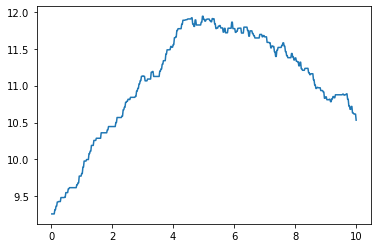

In [11]:
x = data["Time (ps)"]
y = data["Box Volume (nm^3)"]
plt.plot(x,y)
plt.show()